**Import Library**

In [1]:
import re
import os
import time

import numpy as np
import pandas as pd
import tensorflow as tf
import plotly.graph_objects as go
import matplotlib.pyplot as plt

from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model
from keras_self_attention import SeqSelfAttention
from tensorflow.keras.layers import Embedding, LSTM, Dense, Flatten
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.callbacks import EarlyStopping
from underthesea import word_tokenize
from collections import Counter
import fasttext


#from google.colab import drive
#drive.mount('/content/gdrive')


#path = "/content/gdrive/MyDrive/KLTN/"


**Read data & Visualize**

In [2]:
#dt = pd.read_csv("data/vbpl.csv", encoding="utf-8")
#dt.head()

dt = pd.read_csv("data/tvpl.csv", encoding="utf-8")
dt.head()

,Loại,Thực thể tham chiếu,Quan hệ,Trước,Thực thể được tham chiếu,Sau
0,HP,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,CC,căn_cứ,Hiến_pháp nước cộng_hoà xã_hội chủ_nghĩa việt_nam,NaN
1,LT,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,"trường_hợp cơ_quan , đơn_vị , tổ_chức thực_hiệ...",Luật quản_lí thuế_tính trên số,tiền chậm trả và thời_gian chậm trả
2,CT,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,một trong các giấy_tờ được lập trong quá_trình...,Chỉ_thị số 299/tg ngày 10 tháng 11 năm 1980,"của thủ_tướng chính_phủ về công_tác đo_đạc , p..."
3,CT,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,giấy_tờ của đơn_vị quốc_phòng giao đất cho cán...,Chỉ_thị số 282/ct-qp ngày 11 tháng 7 năm 1991,của bộ_trưởng bộ quốc_phòng mà việc giao đất đ...
4,NĐ,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,hợp_đồng mua_bán nhà ở thuộc sở_hữu nhà_nước t...,Nghị_định số 61-cp ngày 05 tháng 7 năm 1994,của chính_phủ về mua_bán và kinh_doanh nhà ở h...


In [3]:
A = "Thực thể tham chiếu"
Label = "Quan hệ"
B = "Thực thể được tham chiếu"
After_B = "Trước"
Before_B = "Sau"

data_Clean = dt[[A,Label,After_B,B,Before_B]].copy()
data_Clean[Label] = dt[Label].fillna('None')
data_Clean[[A, B]].dropna()
data_Clean.info()


data_Clean['Quan hệ'].unique()
data_Clean.head(10)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97626 entries, 0 to 97625
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Thực thể tham chiếu       97626 non-null  object
 1   Quan hệ                   97626 non-null  object
 2   Trước                     77294 non-null  object
 3   Thực thể được tham chiếu  97626 non-null  object
 4   Sau                       69685 non-null  object
dtypes: object(5)
memory usage: 3.7+ MB


,Thực thể tham chiếu,Quan hệ,Trước,Thực thể được tham chiếu,Sau
0,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,CC,căn_cứ,Hiến_pháp nước cộng_hoà xã_hội chủ_nghĩa việt_nam,NaN
1,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,"trường_hợp cơ_quan , đơn_vị , tổ_chức thực_hiệ...",Luật quản_lí thuế_tính trên số,tiền chậm trả và thời_gian chậm trả
2,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,một trong các giấy_tờ được lập trong quá_trình...,Chỉ_thị số 299/tg ngày 10 tháng 11 năm 1980,"của thủ_tướng chính_phủ về công_tác đo_đạc , p..."
3,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,giấy_tờ của đơn_vị quốc_phòng giao đất cho cán...,Chỉ_thị số 282/ct-qp ngày 11 tháng 7 năm 1991,của bộ_trưởng bộ quốc_phòng mà việc giao đất đ...
4,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,hợp_đồng mua_bán nhà ở thuộc sở_hữu nhà_nước t...,Nghị_định số 61-cp ngày 05 tháng 7 năm 1994,của chính_phủ về mua_bán và kinh_doanh nhà ở h...
5,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,giấy_tờ về sở_hữu nhà ở do cơ_quan có thẩm_quy...,Nghị_quyết số 23/2003/qh11 ngày 26 tháng 11 nă...,của quốc_hội về nhà_đất do nhà_nước đã quản_lí...
6,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,NaN,Nghị_quyết số 755/2005/nq-ubtvqh11 ngày 02 thá...,của uỷ_ban thường_vụ quốc_hội quy_định việc gi...
7,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DSD,"sửa_đổi , bổ_sung một_số điều của",Luật quy_hoạch số 21/2017/qh14,"đã được sửa_đổi , bổ_sung một_số điều theo"
8,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,NaN,Luật số 15/2023/qh15,","
9,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,NaN,Luật số 16/2023/qh15,và Luật số 28/2023/qh15


In [4]:
groups = data_Clean.groupby(by=Label).count()[A]
fig = go.Figure()
fig.add_trace(go.Bar(
    x=groups.index,
    y=groups,
    marker_color='cadetblue',
    width=[0.4, 0.4]))
fig.update_layout(title='Classes and their number in the dataset', title_x=0.5)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'marker': {'color': 'cadetblue'},
              'type': 'bar',
              'width': [0.4, 0.4],
              'x': array(['BTT', 'CC', 'DC', 'DHD', 'DSD', 'HHL', 'None'], dtype=object),
              'y': array([ 2233, 32498, 42614,  1129,  2904,  1082, 15166], dtype=int64)}],
    'layout': {'template': '...', 'title': {'text': 'Classes and their number in the dataset', 'x': 0.5}}
})

**Preprocessing**

In [5]:
def load_dicchar():
    dic = {}
    char1252 = 'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ'.split(
        '|')
    charutf8 = "à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ".split(
        '|')
    for i in range(len(char1252)):
        dic[char1252[i]] = charutf8[i]
    return dic

# Chuyển đổi mã kí tự 1252 sang UTF-8
def covert_unicode(text):
    dicchar = load_dicchar()
    return re.sub(
        r'à|á|ả|ã|ạ|ầ|ấ|ẩ|ẫ|ậ|ằ|ắ|ẳ|ẵ|ặ|è|é|ẻ|ẽ|ẹ|ề|ế|ể|ễ|ệ|ì|í|ỉ|ĩ|ị|ò|ó|ỏ|õ|ọ|ồ|ố|ổ|ỗ|ộ|ờ|ớ|ở|ỡ|ợ|ù|ú|ủ|ũ|ụ|ừ|ứ|ử|ữ|ự|ỳ|ý|ỷ|ỹ|ỵ|À|Á|Ả|Ã|Ạ|Ầ|Ấ|Ẩ|Ẫ|Ậ|Ằ|Ắ|Ẳ|Ẵ|Ặ|È|É|Ẻ|Ẽ|Ẹ|Ề|Ế|Ể|Ễ|Ệ|Ì|Í|Ỉ|Ĩ|Ị|Ò|Ó|Ỏ|Õ|Ọ|Ồ|Ố|Ổ|Ỗ|Ộ|Ờ|Ớ|Ở|Ỡ|Ợ|Ù|Ú|Ủ|Ũ|Ụ|Ừ|Ứ|Ử|Ữ|Ự|Ỳ|Ý|Ỷ|Ỹ|Ỵ',
        lambda x: dicchar[x.group()], text)

def text_preprocessing(document):
    # Chuyển đổi mã kí tự 1252 sang UTF-8
    document['Text'] = document['Text'].apply(covert_unicode)
    # Đưa về dạng chữ thường
    document['Text'] = document['Text'].str.lower()
    # xóa các ký tự không cần thiết
    document['Text'] = document['Text'].apply(lambda x: re.sub(r'[^\w\s]', '', str(x)))
    document = document['Text'].apply(lambda y: re.sub(r'[^\s\wáàảãạăắằẳẵặâấầẩẫậéèẻẽẹêếềểễệóòỏõọôốồổỗộơớờởỡợíìỉĩịúùủũụưứừửữựýỳỷỹỵđ_]',' ',str(y)))
    return document

In [6]:
dt_clean =  data_Clean.loc[data_Clean[Label].isin(groups.index)].reset_index(drop=True)
dt_clean.info()
dt_clean.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97626 entries, 0 to 97625
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Thực thể tham chiếu       97626 non-null  object
 1   Quan hệ                   97626 non-null  object
 2   Trước                     77294 non-null  object
 3   Thực thể được tham chiếu  97626 non-null  object
 4   Sau                       69685 non-null  object
dtypes: object(5)
memory usage: 3.7+ MB


,Thực thể tham chiếu,Quan hệ,Trước,Thực thể được tham chiếu,Sau
0,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,CC,căn_cứ,Hiến_pháp nước cộng_hoà xã_hội chủ_nghĩa việt_nam,NaN
1,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,"trường_hợp cơ_quan , đơn_vị , tổ_chức thực_hiệ...",Luật quản_lí thuế_tính trên số,tiền chậm trả và thời_gian chậm trả
2,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,một trong các giấy_tờ được lập trong quá_trình...,Chỉ_thị số 299/tg ngày 10 tháng 11 năm 1980,"của thủ_tướng chính_phủ về công_tác đo_đạc , p..."
3,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,giấy_tờ của đơn_vị quốc_phòng giao đất cho cán...,Chỉ_thị số 282/ct-qp ngày 11 tháng 7 năm 1991,của bộ_trưởng bộ quốc_phòng mà việc giao đất đ...
4,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,hợp_đồng mua_bán nhà ở thuộc sở_hữu nhà_nước t...,Nghị_định số 61-cp ngày 05 tháng 7 năm 1994,của chính_phủ về mua_bán và kinh_doanh nhà ở h...


In [7]:

dt_clean['Text'] = dt_clean['Thực thể tham chiếu'] + ' ' + dt_clean['Trước'] + ' ' + dt_clean['Thực thể được tham chiếu'] + ' ' + dt_clean['Sau']
dt_clean =  dt_clean.dropna()

# dt_clean['Text'] = dt_clean.apply(lambda d: f'{d[A]} {d[Before_B]} {d[B]} {d[After_B]}'.strip(), axis=1)

dt_clean.head()

,Thực thể tham chiếu,Quan hệ,Trước,Thực thể được tham chiếu,Sau,Text
1,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,"trường_hợp cơ_quan , đơn_vị , tổ_chức thực_hiệ...",Luật quản_lí thuế_tính trên số,tiền chậm trả và thời_gian chậm trả,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...
2,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,một trong các giấy_tờ được lập trong quá_trình...,Chỉ_thị số 299/tg ngày 10 tháng 11 năm 1980,"của thủ_tướng chính_phủ về công_tác đo_đạc , p...",Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...
3,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,giấy_tờ của đơn_vị quốc_phòng giao đất cho cán...,Chỉ_thị số 282/ct-qp ngày 11 tháng 7 năm 1991,của bộ_trưởng bộ quốc_phòng mà việc giao đất đ...,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...
4,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,hợp_đồng mua_bán nhà ở thuộc sở_hữu nhà_nước t...,Nghị_định số 61-cp ngày 05 tháng 7 năm 1994,của chính_phủ về mua_bán và kinh_doanh nhà ở h...,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...
5,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC,giấy_tờ về sở_hữu nhà ở do cơ_quan có thẩm_quy...,Nghị_quyết số 23/2003/qh11 ngày 26 tháng 11 nă...,của quốc_hội về nhà_đất do nhà_nước đã quản_lí...,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...


In [8]:
dt_preprocess =  dt_clean[['Text', 'Quan hệ']].copy()
dt_preprocess.head()


,Text,Quan hệ
1,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC
2,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC
3,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC
4,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC
5,Luật số 31/2024/qh15 ngày 18 tháng 01 năm 2024...,DC


In [9]:
dt_preprocess['Text'] = text_preprocessing(dt_preprocess)
dt_preprocess.head()

,Text,Quan hệ
1,luật số 312024qh15 ngày 18 tháng 01 năm 2024 c...,DC
2,luật số 312024qh15 ngày 18 tháng 01 năm 2024 c...,DC
3,luật số 312024qh15 ngày 18 tháng 01 năm 2024 c...,DC
4,luật số 312024qh15 ngày 18 tháng 01 năm 2024 c...,DC
5,luật số 312024qh15 ngày 18 tháng 01 năm 2024 c...,DC


**Text Length**

In [10]:
def check_length(data):
    min_length = float('inf')
    max_length = 0
    total_length = 0
    count = 0
    length_counts = {}

    for text in data:
        length = len(text)

        # Update minimum length
        if length < min_length:
            min_length = length
            m = count

        # Update maximum length
        if length > max_length:
            max_length = length

        # Update total length for average calculation
        total_length += length

        # Update length counts for mode calculation
        if length in length_counts:
            length_counts[length] += 1
        else:
            length_counts[length] = 1

        count += 1

    average_length = round(total_length / count)
    mode_length = max(length_counts, key=length_counts.get)
    print("Minimum length:", min_length)
    print("Maximum length:", max_length)
    print("Average length:", average_length)
    print("Mode length:", mode_length)


check_length(dt_preprocess['Text'])

Minimum length: 95
Maximum length: 1078
Average length: 270
Mode length: 243


In [11]:
max_length = 250  # Chiều dài tối đa của câu lấy theo độ dài trung bình của toàn bộ tập dữ liệu


**Tokenization**

In [12]:
def tokenization(data):
    Text_col = data
    tokenizer = Tokenizer(split=' ')
    tokenizer.fit_on_texts(Text_col)
    words_to_index = tokenizer.word_index
    vocab_size = len(words_to_index) + 1

    # chuyển đổi dữ liệu văn bản thành các chuỗi số
    tokenizer_seq = tokenizer.texts_to_sequences(Text_col)

    # Đảm bảo mỗi sequece có cùng độ dài
    # 'post' có nghĩa là thêm padding vào cuối mỗi sequence
    # 'pre' có nghĩa là thêm padding vào đầu mỗi sequence
    tokenizer_pad = pad_sequences(tokenizer_seq, padding='post', maxlen=max_length)

    return tokenizer_pad, vocab_size, words_to_index

In [13]:
# Tách từ
data_tokenizer = dt_preprocess.copy()
data_tokenizer['Text'] = data_tokenizer['Text'].apply(word_tokenize)

data_tokenizer.info()
data_tokenizer.head()


data_tokenizer_pad, vocab_size, words_to_index = tokenization(data_tokenizer['Text'])

<class 'pandas.core.frame.DataFrame'>
Index: 52212 entries, 1 to 97625
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   Text     52212 non-null  object
 1   Quan hệ  52212 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


In [14]:
print(data_tokenizer_pad)

[[  29    2 2028 ...    0    0    0]
 [  29    2 2028 ...    0    0    0]
 [  29    2 2028 ...    0    0    0]
 ...
 [   9    2 1213 ...    0    0    0]
 [   9    2 1213 ...    0    0    0]
 [   9    2 1213 ...    0    0    0]]


**Embedding**

In [ ]:
with open('model/fasttext/text_tvpl_2.txt', 'w', encoding="utf-8") as file:
    # Write content to the
    for i in dt_preprocess['Text']:
        file.write(i+"\n")

In [ ]:
model_fasttext = fasttext.train_unsupervised('model/fasttext/text_tvpl_2.txt', maxn=0, dim=100)
model_fasttext.save_model('model/fasttext/tvpl_2_fasttext_100d.bin')

In [ ]:
all_text = ' '.join(dt_preprocess['Text'])

# Split the text into individual words
words = all_text.split()

# Count the frequency of each word
word_counts = Counter(words)

# Find the word with the highest frequency
most_common_word, frequency = word_counts.most_common(1)[0]

print("Most common word:", most_common_word)
print("Frequency:", frequency)

Most common word: của
Frequency: 123658


In [15]:
embedding_dim = 100  # Kích thước nhúng


ft = fasttext.load_model('model/fasttext/vbpl_fasttext_100d.bin')
embed_vector_size = ft.get_word_vector('của').shape[0]

embed_vector_matrix = np.zeros((vocab_size, embed_vector_size))

for word, i in words_to_index.items():
    embedding_vector = ft.get_word_vector(word)
    if any(embedding_vector):
        embed_vector_matrix[i] = embedding_vector
    else:
        embed_vector_matrix[i] = np.random.uniform(low=-1, high=1, size= embed_vector_size)

print(f"Max length | input_length      = {max_length}")
print(f"input_dim  | vocab_size        = {vocab_size}")
print(f"output_dim | embed_vector_size = {embed_vector_size}")
print(f"weights = {embed_vector_matrix.shape}")

embedding = Embedding(input_dim=vocab_size, output_dim=embed_vector_size,
                      input_length=max_length, weights=[embed_vector_matrix], trainable=False)

Max length | input_length      = 250
input_dim  | vocab_size        = 17933
output_dim | embed_vector_size = 100
weights = (17933, 100)



**Create Model**

In [16]:
classes = data_tokenizer['Quan hệ'].nunique()
print(f"Number labels = {classes}")

def create_model():
    lstm_units = 128  # Số đơn vị LSTM
    dropout_val = 0.2
    recurrent_dropout = 0.1

    model = Sequential()
    model.add(embedding)
    model.add(LSTM(lstm_units, return_sequences=True, dropout=dropout_val,recurrent_dropout=recurrent_dropout))
    model.add(LSTM(lstm_units, return_sequences=True, dropout=dropout_val,recurrent_dropout=recurrent_dropout))
    model.add(LSTM(lstm_units, return_sequences=True, dropout=dropout_val,recurrent_dropout=recurrent_dropout))
    model.add(SeqSelfAttention())
    model.add(Flatten())
    model.add(Dense(classes, activation="softmax"))

    # Model compiling
    model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

    return model

Number labels = 7


In [17]:
# Chia dataset thành tập training thành train_val và test
X = data_tokenizer_pad
y = data_tokenizer['Quan hệ']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y.values, test_size=0.2, random_state=40)

In [18]:
# encode label
label_encoder = LabelEncoder()
label_encoder.fit(data_tokenizer["Quan hệ"].values)
print('\nLabels:',list(label_encoder.classes_), '\n')
y_train_val = label_encoder.transform(y_train_val)
y_test = label_encoder.transform(y_test)

# Chia train_val thành train và validation
X_train, X_val, y_train, y_val  = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=40)

print("Size Train: ",X_train.shape, y_train.shape)
print("Size Test: ",X_test.shape, y_test.shape)
print("Size Validation: ",X_val.shape, y_val.shape)


Labels: ['BTT', 'CC', 'DC', 'DHD', 'DSD', 'HHL', 'None'] 

Size Train:  (31326, 250) (31326,)
Size Test:  (10443, 250) (10443,)
Size Validation:  (10443, 250) (10443,)


**Run**

In [19]:
model = create_model()
#batchSize = round(X_train.shape[0] * 0.075)
batchSize = 128
epoch = 10
#print(batchSize)
model.summary()


c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\initializers\initializers.py:120: UserWarning:

The initializer GlorotNormal is unseeded and being called multiple times, which will return identical values each time (even if the initializer is unseeded). Please update your code to provide a seed to the initializer, or avoid using the same initializer instance more than once.




Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 250, 100)          1793300   
                                                                 
 lstm (LSTM)                 (None, 250, 128)          117248    
                                                                 
 lstm_1 (LSTM)               (None, 250, 128)          131584    
                                                                 
 lstm_2 (LSTM)               (None, 250, 128)          131584    
                                                                 
 seq_self_attention (SeqSel  (None, 250, 128)          8257      
 fAttention)                                                     
                                                                 
 flatten (Flatten)           (None, 32000)             0         
                                                       

In [20]:
# Ghi lại thời điểm bắt đầu
start_time = time.time()
checkpoint_path = "".join(['checkpoint','vbpl_ft',"/cp.ckpt"])
checkpoint_dir = os.path.dirname(checkpoint_path)
earlystopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1,patience=2)
checkpointing = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)
lstm_model_history = model.fit(X_train, y_train, batch_size=batchSize, epochs=epoch, callbacks=[earlystopping,checkpointing], validation_data=(X_val, y_val))

# Tính thời gian đã trôi qua
training_time = round(time.time() - start_time, 2)

Epoch 1/10


245/245 [==============================] - ETA: 0s - loss: 0.4722 - accuracy: 0.8508 
Epoch 1: saving model to checkpointvbpl_ft\cp.ckpt
245/245 [==============================] - 5563s 23s/step - loss: 0.4722 - accuracy: 0.8508 - val_loss: 0.2184 - val_accuracy: 0.9353
Epoch 2/10
245/245 [==============================] - ETA: 0s - loss: 0.2155 - accuracy: 0.9330 
Epoch 2: saving model to checkpointvbpl_ft\cp.ckpt
245/245 [==============================] - 6372s 26s/step - loss: 0.2155 - accuracy: 0.9330 - val_loss: 0.1939 - val_accuracy: 0.9412
Epoch 3/10
245/245 [==============================] - ETA: 0s - loss: 0.1779 - accuracy: 0.9448 
Epoch 3: saving model to checkpointvbpl_ft\cp.ckpt
245/245 [==============================] - 6336s 26s/step - loss: 0.1779 - accuracy: 0.9448 - val_loss: 0.1463 - val_accuracy: 0.9544
Epoch 4/10
245/245 [==============================] - ETA: 0s - loss: 0.1422 - accuracy: 0.9556 
Epoch 4: saving model to checkpointvbpl_ft\cp.ckpt
245/

**Save Model**

In [21]:
# thu tu cac chi so: maxLength_Batch_epochs_dropout_recurrentDropout
path = f"model/classify_law_rel_fasttext_with_preprocess_tvpl_{max_length}_128lstmunits_{batchSize}_{epoch}_{0.2}_{0.1}_{X_train.shape[0]}_{training_time}.h5"

print(path)
model.save(path)

model/classify_law_rel_fasttext_with_preprocess_tvpl_250_128lstmunits_128_10_0.2_0.1_31326_54681.73.h5


c:\Users\Administrator\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning:

You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.



**Prediction**

In [22]:
# Predictions on the Test Set
score = model.evaluate(X_test, y_test)

# Model Performance
print("Test Score:", score[0])
print("Test Accuracy:", score[1])

327/327 [==============================] - 125s 380ms/step - loss: 0.0926 - accuracy: 0.9727
Test Score: 0.09256422519683838
Test Accuracy: 0.9727090001106262


In [23]:
start = None
end = None

# Phân loại 
y_pred = model.predict(X_test[start:end])
# Mã hóa label
y_pred_original = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
y_test_original = label_encoder.inverse_transform(y_test[start:end])

# In ra kết quả phân loại
print(f"Kết quả thực tế: {y_test_original}")
print(f"Kết quả mô hình phân loại: {y_pred_original} - {y_pred_original == y_test_original}")

327/327 [==============================] - 117s 353ms/step
Kết quả thực tế: ['DC' 'CC' 'DC' ... 'CC' 'DC' 'BTT']
Kết quả mô hình phân loại: ['DC' 'CC' 'DC' ... 'CC' 'DC' 'None'] - [ True  True  True ...  True  True False]


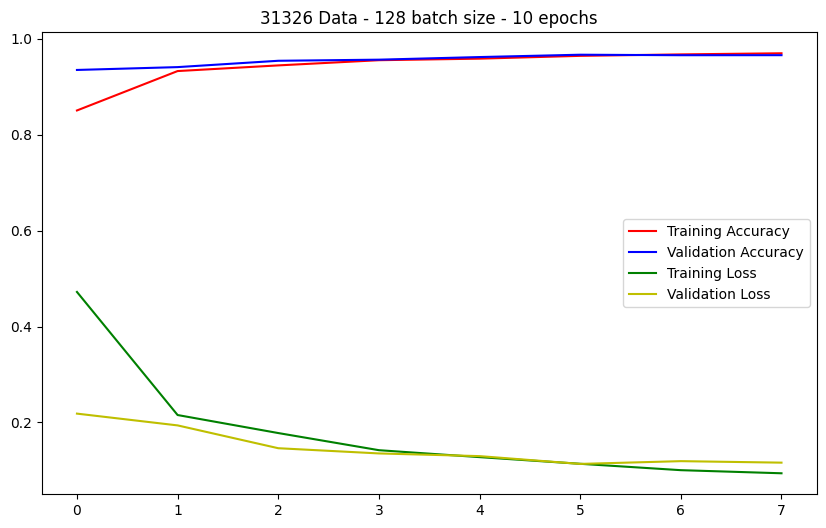

In [24]:
def plot_graph(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))

    plt.figure(figsize=(10,6))
    plt.plot(epochs, acc, 'r', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'b', label='Validation Accuracy')
    plt.plot(epochs, loss, 'g', label='Training Loss')
    plt.plot(epochs, val_loss, 'y', label='Validation Loss')

    plt.title(f'{X_train.shape[0]} Data - {batchSize} batch size - {epoch} epochs')
    plt.legend(loc=0)
    plt.savefig(f'images/law_fasttext_with_preprocess_tvpl_{max_length}_128lstmunits_{batchSize}_{epoch}_0.2_0.1_{X_train.shape[0]}_{training_time}.png')
    plt.show()


plot_graph(lstm_model_history)

In [25]:
# Calculate precision, recall, and F1 score for each class
precision_per_class = precision_score(y_test_original, y_pred_original, average=None)
recall_per_class = recall_score(y_test_original, y_pred_original, average=None)
f1_per_class = f1_score(y_test_original, y_pred_original, average=None)

# Calculate macro-average precision, recall, and F1 score
macro_precision = round(np.mean(precision_per_class),3)
macro_recall = round(np.mean(recall_per_class),3)
macro_f1 = round(np.mean(f1_per_class),3)

# Create a DataFrame for the table
metrics_table_per_class = pd.DataFrame({
    'Class': np.unique(y_test_original),
    'Precision': precision_per_class,
    'Recall': recall_per_class,
    'F1 Score': f1_per_class
})

# Print the table per class
print("Metrics Table per Class:")
print(metrics_table_per_class)

# Print macro-average metrics
print("\nMacro-Average Metrics:")
print(f"Macro Precision: {macro_precision}")
print(f"Macro Recall: {macro_recall}")
print(f"Macro F1 Score: {macro_f1}")

Metrics Table per Class:
  Class  Precision    Recall  F1 Score
0   BTT   0.901734  0.812500  0.854795
1    CC   0.994489  0.989358  0.991917
2    DC   0.985927  0.979798  0.982853
3   DHD   0.696429  0.787879  0.739336
4   DSD   0.949227  0.905263  0.926724
5   HHL   0.937500  0.555556  0.697674
6  None   0.918683  0.975732  0.946348

Macro-Average Metrics:
Macro Precision: 0.912
Macro Recall: 0.858
Macro F1 Score: 0.877


**Confusion Matrix**

In [26]:
# Tìm tất cả các nhãn duy nhất
labels = np.unique(np.concatenate((y_test_original, y_pred_original)))

# Tạo ma trận confusion
confusion = confusion_matrix(y_test_original, y_pred_original, labels=labels)

print("Ma trận confusion:")
print(confusion)

Ma trận confusion:
[[ 156    0    4    0    3    0   29]
 [   0 3068   18   12    0    0    3]
 [   3    8 5044   14   16    0   63]
 [   0    3   15   78    0    0    3]
 [   7    0   14    5  430    0   19]
 [   3    0    2    1    2   15    4]
 [   4    6   19    2    2    1 1367]]
